In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import show
from bokeh.layouts import column

print(os.getcwd())

levels = ['genes', 'proteins', 'proteoforms']

C:\git\PathwayAnalysisPlatform\ProteoformNetworks\src\Python


In [2]:
# What is fixed for all sources? These files are generated following the Replication.md instructions in the Wiki.
## genes, proteins and proteoforms universe list (full network nodes)
## genes, proteins and proteoforms interactions (full network links)
## Mapping from genes to proteins, and from proteins to proteoforms

from lib.data_read_write import create_pathwaymatcher_files
from config import PATH_REACTOME, FILE_REACTOME_GENES, FILE_REACTOME_PROTEINS, FILE_REACTOME_PROTEOFORMS, \
    FILE_REACTOME_GENE_INTERACTIONS, FILE_REACTOME_PROTEIN_INTERACTIONS, FILE_REACTOME_PROTEOFORM_INTERACTIONS, \
    PATH_RESOURCES, FILE_PATHWAYMATCHER, URL_PATHWAYMATCHER, FILE_PROTEOFORMS_SEARCH

create_pathwaymatcher_files("../../" + PATH_REACTOME, FILE_REACTOME_GENES, FILE_REACTOME_PROTEINS,
                            FILE_REACTOME_PROTEOFORMS, FILE_REACTOME_GENE_INTERACTIONS,
                            FILE_REACTOME_PROTEIN_INTERACTIONS, FILE_REACTOME_PROTEOFORM_INTERACTIONS,
                            FILE_PROTEOFORMS_SEARCH,
                            PATH_RESOURCES, FILE_PATHWAYMATCHER, URL_PATHWAYMATCHER)

PathwayMatcher files READY


In [3]:
# What is needed from each source? 
## Gene/Protein Modules file (network regions)

# PheGenI Phenotypes
from lib.download import download_if_not_exists
download_if_not_exists("../../resources/PheGenI/", 
                       "PheGenI_Association.txt", 
                       "https://www.ncbi.nlm.nih.gov/projects/gap/eqtl/EpiViewBE.cgi?type=dl.tab",
                       "PheGenI modules")

# Jensen Lab Diseases
download_if_not_exists("../../resources/Jensen/",
                       "human_disease_textmining_filtered.tsv",
                       "http://download.jensenlab.org/human_disease_textmining_filtered.tsv",
                       "Jensen Lab Diseases")

# from lib.conversions import create_gene_to_protein_mapping
# 
# path_file_genes = "../../../resources/Reactome/v70/Genes/all_genes_v70.csv"
# create_gene_to_protein_mapping(path_file_genes, "../../../resources/UniProt/", "mapping_proteins_to_genes_v70.tab", 1000)
dataset="PheGenI" 
# dataset="Pathways" 
# dataset="Jensen" 

In [4]:
# Generates module files: gene_modules.tsv, protein_modules.tsv and proteoform_modules.tsv
# Generates single module files at each level: gene, protein and proteoform file for each trait
# Module sizes for genes, protein and proteoform levels
# Variation in module sizes when going from one level to the other
# Three files (for genes, proteins and proteoforms) with the Overlap similarity of each 
# pair of traits.
# Creates a file with a selection of trait pair examples which show decrease in the overlap. 

In [30]:
sizes_dict = {level: pd.read_csv(f"../../reports/module_sizes_{level}.tsv", sep="\t") for level in levels}
for level in levels:
    print(f"\n{level}")
    print(sizes_dict[level].describe())


sizes_df = pd.concat(sizes_dict, names=["level", "index"])
sizes_df[sizes_df.index.get_level_values("level") == "genes"]


genes
             SIZE
count  792.000000
mean     3.445707
std     11.633449
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    141.000000

proteins
             SIZE
count  792.000000
mean     4.707071
std     14.607725
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    140.000000

proteoforms
             SIZE
count  792.000000
mean     7.037879
std     23.795081
min      0.000000
25%      0.000000
50%      0.000000
75%      2.000000
max    283.000000


MODULE  SIZE
level index                                                         
genes 0                                ADAMTS13 protein, human     0
      1      Amyloidosis, Cerebral, with Spongiform Encepha...     0
      2                                    Anemia, Sickle Cell    11
      3                                Antibodies, Antinuclear     0
      4                           Antibodies, Antiphospholipid     0
...                                                        ...   ...
      787                                         temozolomide     0
      788                         thiopurine methyltransferase     0
      789                        thyroid microsomal antibodies     0
      790                                von Willebrand Factor     0
      791                                          ziprasidone     0

[792 rows x 2 columns]

<Figure size 936x432 with 0 Axes>

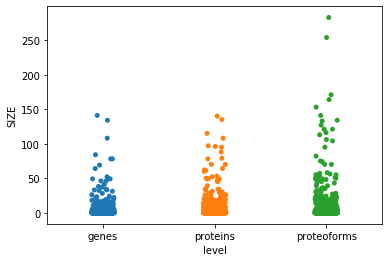

In [38]:
# Do the following plots for the modules in two cases: keeping disconnected nodes and removing them
    # Jitter plot showing the sizes for genes, proteins and proteoforms
    # Jitter plot showing the difference in size fom genes to proteins and from proteins to proteoforms.
# sizes_df = pd.DataFrame()
# for level in levels:
#     sizes_df[f"SIZES_{level.upper()}"] = sizes_dict[level]["SIZES"]

sizes_stripplot = sns.stripplot(x=sizes_df.index.get_level_values("level"), y="SIZE", data=sizes_df)
plt.show()


In [ ]:
sizes_genes = pd.read_csv(f"../../reports/module_sizes_genes.tsv", sep="\t")
sizes_genes
sizes_proteins = pd.read_csv(f"../../reports/module_sizes_proteins.tsv", sep="\t")
sizes_proteoforms = pd.read_csv(f"../../reports/module_sizes_proteoforms.tsv", sep="\t")

sizes = pd.DataFrame(sizes_genes['SIZE'])
sizes.columns = ['SIZE_GENES']
sizes['SIZE_PROTEINS'] = sizes_proteins['SIZE']
sizes['SIZE_PROTEOFORMS'] = sizes_proteoforms['SIZE']
sizes['SIZE_VARIATION'] = sizes['SIZE_PROTEOFORMS'] - sizes['SIZE_GENES']
sizes['PERCENTAGE_VARIATION'] = sizes['SIZE_VARIATION']*100/sizes['SIZE_GENES']
sizes['PERCENTAGE_VARIATION'].fillna(0, inplace=True)
sizes['PERCENTAGE_VARIATION'].unique()
sizes.index = sizes_genes['MODULE']
sizes

Text(0, 0.5, 'Density')

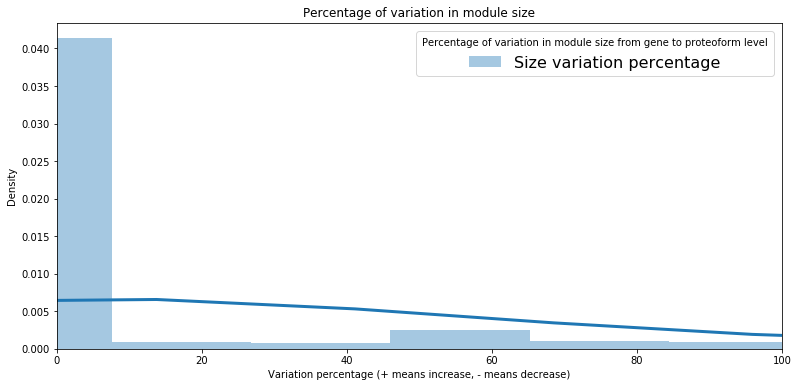

In [7]:
plt.figure(figsize=(13, 6))
dp = sns.distplot(sizes['PERCENTAGE_VARIATION'] , hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = "Size variation percentage", bins=125)
dp.set(xlim=(0, 100))
plt.legend(prop={'size': 16}, title = 'Percentage of variation in module size from gene to proteoform level')
plt.title('Percentage of variation in module size')
plt.xlabel('Variation percentage (+ means increase, - means decrease)')
plt.ylabel('Density')


In [8]:
scores = {level: pd.read_csv(f"../../reports/scores_{level}_overlap_similarity.tsv", sep='\t') for level in levels}
assert len({len(scores[level]) for level in levels}) == 1, "Error: the number of modules vary among levels."

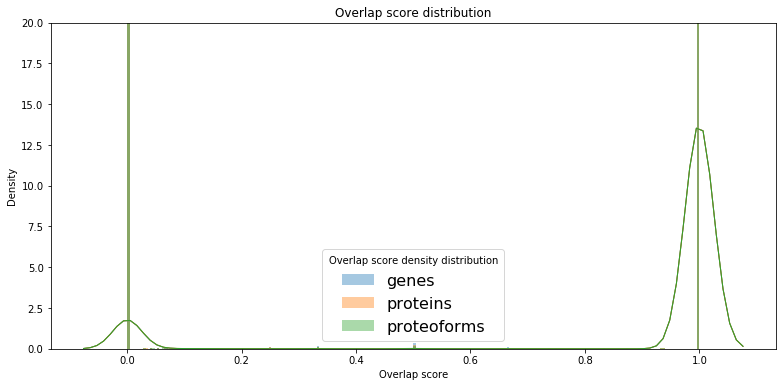

In [9]:
import matplotlib.pyplot as plt

bins = 250
plt.figure(figsize=(13, 6), )
for level in levels:
    sns.distplot(scores[level]['SCORE'] , hist = True, kde = True, kde_kws = {'linewidth': 1}, label=level, bins=bins)
plt.ylim(0, 20)
plt.legend(prop={'size': 16}, title = 'Overlap score density distribution')
plt.title('Overlap score distribution')
plt.xlabel('Overlap score')
plt.ylabel('Density')
plt.show()

In [10]:
df = pd.DataFrame(scores['genes'][['SCORE', 'OVERLAP_SIZE']])
df.columns = ['SCORE_GENES', 'OVERLAP_SIZE_GENES']
for level in ['proteins', 'proteoforms']:
    df['OVERLAP_SIZE_' + level.upper()] = scores[level]['OVERLAP_SIZE']
    df['SCORE_' + level.upper()] = scores[level]['SCORE']
df['SCORE_VARIATION'] = df['SCORE_PROTEOFORMS'] - df['SCORE_GENES'] 
df['SIZE_PERCENTAGE_VARIATION'] = scores['genes'].apply(lambda x: sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT1']] + sizes['PERCENTAGE_VARIATION'].loc[x['TRAIT2']], axis=1)
df.index = scores['genes'].apply(lambda x: (x['TRAIT1'], x['TRAIT2']), axis=1)
df

,SCORE_GENES,OVERLAP_SIZE_GENES,OVERLAP_SIZE_PROTEINS,SCORE_PROTEINS,OVERLAP_SIZE_PROTEOFORMS,SCORE_PROTEOFORMS,SCORE_VARIATION,SIZE_PERCENTAGE_VARIATION
"(ADAMTS13 protein, human, Amyloidosis, Cerebral, with Spongiform Encephalopathy)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Anemia, Sickle Cell)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antibodies, Antinuclear)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antibodies, Antiphospholipid)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antidepressive Agents, Tricyclic)",1.0,0,0,1.0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
"(thiopurine methyltransferase, von Willebrand Factor)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(thiopurine methyltransferase, ziprasidone)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(thyroid microsomal antibodies, von Willebrand Factor)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(thyroid microsomal antibodies, ziprasidone)",1.0,0,0,1.0,0,1.0,0.0,0.0


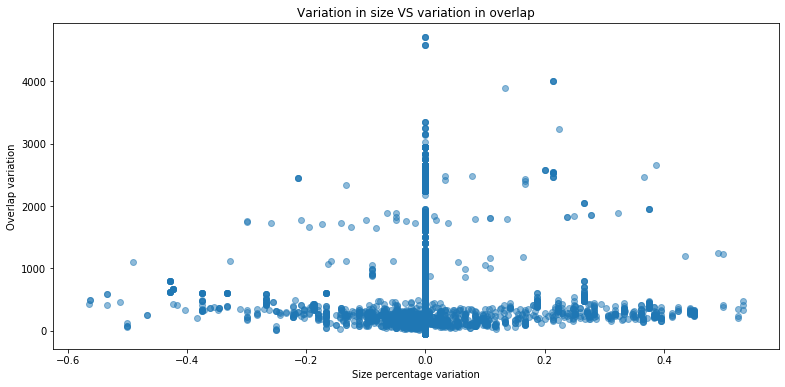

In [11]:
plt.figure(figsize=(13, 6))
plt.scatter(df['SCORE_VARIATION'], df['SIZE_PERCENTAGE_VARIATION'], alpha=0.5)
plt.title('Variation in size VS variation in overlap')
plt.xlabel('Size percentage variation')
plt.ylabel('Overlap variation')
plt.show()

In [12]:
min_overlap_size = 10
max_overlap_size = 20
df = df.loc[(df['OVERLAP_SIZE_PROTEOFORMS'] >= min_overlap_size) 
       & (df['OVERLAP_SIZE_PROTEOFORMS'] <= max_overlap_size)
        & df['SCORE_PROTEOFORMS'] < df['SCORE_GENES']]
df.to_csv(f"../../reports/overlap_similarity_score_variation_examples_{min_overlap_size}_{max_overlap_size}.tsv", sep='\t')


# sizes['PERCENTAGE_VARIATION'].unique()
# # df["SIZE_PERCENTAGE_VARIATION"].unique()
# [print(sizes['PERCENTAGE_VARIATION'].loc[x[0]], '\t', sizes['PERCENTAGE_VARIATION'].loc[x[1]], '\t', sizes['PERCENTAGE_VARIATION'].loc[x[0]] + sizes['PERCENTAGE_VARIATION'].loc[x[1]]) for x in df.index]

In [13]:
print(len(df))
df.head()


277182


,SCORE_GENES,OVERLAP_SIZE_GENES,OVERLAP_SIZE_PROTEINS,SCORE_PROTEINS,OVERLAP_SIZE_PROTEOFORMS,SCORE_PROTEOFORMS,SCORE_VARIATION,SIZE_PERCENTAGE_VARIATION
"(ADAMTS13 protein, human, Amyloidosis, Cerebral, with Spongiform Encephalopathy)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Anemia, Sickle Cell)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antibodies, Antinuclear)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antibodies, Antiphospholipid)",1.0,0,0,1.0,0,1.0,0.0,0.0
"(ADAMTS13 protein, human, Antidepressive Agents, Tricyclic)",1.0,0,0,1.0,0,1.0,0.0,0.0
